# Deep Learning HW01
Gerald Baulig 0780827 2019/11/05
GitHub: https://github.com/bugerry87/fcnn_scratch

---

In this assignment we are asked to implement a neural network from scratch,
including Back Propagation and Storastic Gradient Decent algorithms.
The assigment includes two tasks:

1. Implement a regression network, and
2. implement a classification network.

# A Neural Network from Scratch

First, let's define what a Neural Network is.
A Neural Network is a class that can train and validate the weight of a stack of layers, w.r.t several hyper-parameters.
However, all what the Neural Network needs to know about his own network is, where to get its output from. Furthermore, the hyper-parameters are only required in the training process, but only few of them in the validation process,
such that the class defination could look like that:

In [125]:
class NeuralNetwork:
    def __init__(self, train_set, val_set, cost_func, loss_func):
        '''Initialization of NeuralNetwork
        
        Args:
            train_set: A generator that iterates through training data.
            val_set: A generator that iterates through validation data.
            cost_func: A cost function minimized during training.
            loss_func: A loss function for performance validation.
        '''
        self.train_set = train_set
        self.val_set = val_set
        self.cost = cost_func
        self.loss = loss_func
        self.training = False
        pass
    
    def train(self, output_layer, lr, lr_dec):
        '''A generator function processes and iterates through the training steps.
        
        Computes the cost performs the Back Propagation and updates the params.
        Yields for each batch.
        
        Args:
            output_layer: The output layer whose Y gets tested against the cost function.
            lr: The learning-rate, determines how much of the gradient gets adapted to the params.
            lr_dec: A decay rate, decays the learning rate per epoch.
        
        Yields:
            L: The cost
        '''
        self.lr = lr
        self.lr_dec = lr_dec
        self.training = True
        for Y in output_layer.pull_forward():
            L = np.squeeze(self.cost.f(self.T, Y))
            dL = self.cost.d(self.T, Y)
            output_layer.push_backward(dL, self.lr)
            self.lr -= self.lr * self.lr_dec
            yield L
        pass
    
    def val(self, output_layer):
        '''A generator function processes and iterates through the validation steps.
        
        Evaluates the loss.
        Yields for each batch.
        
        Args:
            output_layer: The output layer whose Y gets tested against the loss function.
        
        Yields:
            L: The loss
        '''
        self.training = False
        for Y in output_layer.pull_forward():
            L = self.loss.f(self.T, Y)
            yield L
        pass        
    
    def gen_input(self):
        '''A generator that pulls the inputs either from the training or the validation set.
        
        Switch between the sets by setting the training flag.
        
        Yields:
            X: A sample either from train_set or val_set.
        '''
        if self.training:
            for self.X, self.T, self.epoch, self.step in self.train_set():
                yield self.X
        else:
            for self.X, self.T, _, _ in self.val_set():
                yield self.X
        pass

## Let's Define a Fully-Connected Layer

A Fully-Connected Layer of a Neural Network can be defined as a set of neurons.
Each neuron implcates an input-node that propagates multiple outputs scaled by weights,
such that the neurons can be descriped in a 2-dimensional matrix \[#inputs, #outputs\] or likewise \[#neurons, #weights\].
This matrix we name simply 'weights'.
Furthermore, each neuron has a bias for a more soft generalization.
Bias is just an additional vector this the length of #neurons.
All the outputs of a layer pass through an activation function to the next upper layer,
such that a layer requires an function-pointer to those activation functions.
Furthermore, the layer requires a referenze to the input-source and a referenze for the Back Propagation.

### Feed Forward

Assume $A_i(x)$ is any kind of activation function, while $W_i$ the weights and $b_i$ the bias of a Layer,
then the activation potential of a single Layer could be described as:

$$
\begin{equation}
Z_i (x) = W_i x + b_i = z_i
\tag{1.1}
\end{equation}
$$

$$
\begin{equation}
f_i(x) = A_i (Z_i (x)) = y_i
\tag{1.2}
\end{equation}
$$

Thus, the Feed Forward process of the whole Network becomes a recursive function as:

$$
\begin{equation}
f(x) = f_n (f_2 (f_1 (x))) = y
\tag{1.3}
\end{equation}
$$

### Back Propagation

In the Back Propagation we want to find the gradients of our Network's weights according to the current Loss
and update the weights with a Storastic Gradient Decent approach.
Assume $L$ is a Loss function over a predition $y$ to a target $t$,
while $\frac{dL}{dW}$ is the derivative of the Loss w.r.t all the weight $W$ of our Network,
the derivative would become pretty complex:

$$
\begin{equation}
L(t, y) = L(t, A_n (Z_n (W_n, A_2 (Z_2 (W_2, A_1 (Z_1 (W_1, x))))))) = loss
\tag{2.1}
\end{equation}
$$

Thus, the derivative w.r.t $W$:

$$
\begin{equation}
\frac{dL}{dW} = \frac{dL}{dy_n}*\frac{dy_n}{dz_n}
    *\frac{dz_n}{dy_2}*\frac{dy_2}{dz_2}
    *\frac{dz_2}{dy_1}*\frac{dy_1}{dz_1}
    *\frac{dz_1}{dW}
\tag{2.2}
\end{equation}
$$

Fortunatelly, thanks to the Chain Rule we can do it step-wise recursively for each layer $i$, if we assume $dL = dz_{n+1}$:

$$
\begin{equation}
\frac{dz_{i+1}}{dz_i} = \frac{dz_{i+1}}{dy_i} * \frac{dy_i}{dz_i}
\tag{2.3}
\end{equation}
$$

where:

$$
\begin{equation}
\frac{dz_i}{dy_{i-1}} = W_{i}^T dz_{i}
\tag{2.4}
\end{equation}
$$

In [126]:
class Layer:
    '''A typedef for Neural Network Layers'''
    pass

class FcLayer(Layer):
    '''A simple Fully-Connected Layer
    
    Instead of "feed forward" this impl "pull_forward"
    the output from the lower layer as input to the upper layer
    and performs the back-propagation via "push_backward".
    For "pull_forward" an input generator must be assigned to this layer.
    "pull_forward" is such an input generator,
    such that layers can be connected with each other,
    pulling the output of the underlaying layer to the upper layers,
    up to the final output-layer.
    The back-propagation is a simple function-pointer,
    to the "push_backward" function of the underlaying layer
    '''
    
    def __init__(self,
                 params,
                 act_func,
                 input_func,
                 backprop,
                 clipping=False
                ):
        '''Initializer of FcLayer
        
        Args:
            params: A tuble that contains weights and bias.
            act_func: The activation function.
            input_func: A function that creates an generator.
            backprop: The "push_backward" of another Layer.
            clipping: For clipping the output to a min-&-max value.
                        this may prevent number overflows.
        '''
        self.w = params[0]
        self.b = params[1]
        self.act = act_func
        self.input = input_func
        self.backprop = backprop
        self.clipping = clipping
        pass
    
    def pull_forward(self):
        '''Pulls the output from the underlaying layer. (Feed Forward)
        
        Creates a generator that pulls the input,
        performs the activation and yields the result.
        Stores a referenc to the input as "x"
        and the result as "y".
        If the "act_func" is not monotonic,
        an intermediet result will be stored in "z".
        
        Yields:
            The activation of (wx + b)
        '''
        def z():
            return np.dot(self.x, self.w) + self.b
        
        for self.x in self.input():
            if self.act.monotonic():
                #safe the storage
                self.y = self.act.f(z())
            else:
                self.z = z()
                self.y = self.act.f(self.z)
            yield self.y
    
    def push_backward(self, dZ, lr):
        '''Pushes the loss to the underlaying layer. (Backpropagation)
        
        Performs the beck-propagation recursively based on the given gradient "dZ".
        
        Args:
            dZ: The gradient computed by NeuralNetwork.train
            lr: The current learning-rate
        '''
        dZ *= self.act.d(self.y if self.act.monotonic else self.z) #dz+1/dy * dy/dz
        dw = np.dot(self.x.T, dZ) #zd/wd
        if self.backprop:
            self.backprop(np.dot(dZ, self.w.T), lr) #dz/dy-1 = W * dz
        self.w += dw * lr if not self.clipping else np.clip(dw * lr, -self.clipping, self.clipping)
        if not self.b is 0:
            self.b += np.sum(dZ, axis=0) * lr
        pass

## Some Activation Functions

Let's define a few common activation functions.
An activation functions simulates in analogy of a brain-cell the action-potention the cell fires to the next cells.
This behavior can be very individual, such that many (mostly non-linear) functions can be applied in here.
E.g. a hard binary YES(1) or NO(0) or rather fuzzy activations such as Sigmoid(0..1) or TanH(-1..1).

For each activation function we define, the derviation for the back-propagation is also required,
such that we could descripe an activation function as a static class with $f(x)$ and $f'(x) = d(y)$.

In [127]:
class ActFunc:
    '''A typedef for Activation Functions'''
    def monotonic():
        '''Activation functions are usually monotonic.
        
        Otherwise, override this function with False.
        '''
        return True
    
    def f(x):
        '''The original equition'''
        pass
    
    def d(y):
        '''The derivative'''
        pass

### Sigmoid

A smooth, fuzzy activation function keeping the activation potential in a range of \[0..1\],
with saturation in both directions.
It appears that this activation function is useful to normalize the activation potential of the input-layer with unnormalized data.

$$
\begin{equation}
f(z) = \frac{1}{1 + \exp(-z)} = S = y
\tag{3.1}
\end{equation}
$$

Since Sigmoid is a monotonic function, we can derive Sigmoid w.r.t the result $S$ instead of the input $z$.

$$
\begin{equation}
f'(S) = S * (1 - S) = dy
\tag{3.2}
\end{equation}
$$

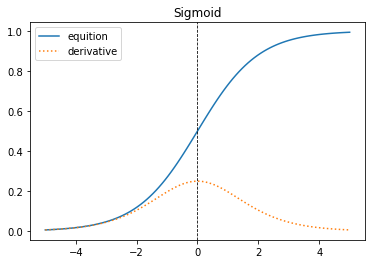

In [210]:
import matplotlib.pylab as plt
import numpy as np

class Sigmoid(ActFunc):
    def f(z):
        return 1 / (1 + np.exp(-z))
    
    def d(S):
        '''Derivative of Sigmoid
        
        Sigmoid is monotonic,
        such that we can forward the activation potential directly.
        
        Args:
            S = Sigmoid.f(z)
            
        Returns:
            Derivative of Sigmoid.f(z)
        '''
        return S * (1 - S)

#test
x = np.linspace(-5,5,100)
plt.plot(x, Sigmoid.f(x), label='equition')
plt.plot(x, Sigmoid.d(Sigmoid.f(x)), ':', label='derivative')
plt.title("Sigmoid")
plt.axvline(color='k', linewidth=0.8, linestyle='--')
plt.legend()
plt.show()

### TanH

Sigmoid fires positive activation potentials only.
This is mostly applicable for classification problems,
where a negative probability is never expected.
However, in regression problems we should also consider negative activation potentials.
Therefore, let's implement TanH:

$$
\begin{equation}
f(x) = \tanh(x) = \alpha
\tag{4.1}
\end{equation}
$$

Thus, the derivative:

$$
\begin{equation}
f'(\alpha) = 1 - \alpha^2
\tag{4.2}
\end{equation}
$$

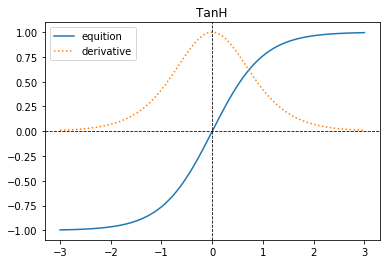

In [208]:
import matplotlib.pylab as plt
import numpy as np

class TanH(ActFunc):
    def f(x):
        return np.tanh(x)
    
    def d(a):
        '''Derivative of TanH
        
        TanH is monotonic,
        such that we can forward the activation potential directly.
        
        Args:
            a = TanH.f(x)
            
        Returns:
            Derivative of TanH.f(x)
        '''
        return 1 - np.power(a, 2)

#test
x = np.linspace(-3,3,100)
plt.plot(x, TanH.f(x), label='equition')
plt.plot(x, TanH.d(TanH.f(x)), ':', label='derivative')
plt.title("TanH")
plt.axvline(color='k', linewidth=0.8, linestyle='--')
plt.axhline(color='k', linewidth=0.8, linestyle='--')
plt.legend()
plt.show()

### ReLU
Rectified Linear Unit is a function more inspired by biologic or electronic phenomenas instead of probability theory.
It was demonstrated that ReLU performs much better in large/deep neural networks, because it prevents saturation and vanishing gradients. On the other hand, ReLU may cause number overflows, since the summation of all weights could become very high. To prevent this, the dataset should be normalized or we start the first Layer with a Sigmoid.
The defination of ReLU is very simple:

$$
\begin{equation}
f(x) = x^+ = \max(x,0) = y
\tag{5.1}
\end{equation}
$$

Likewise the derivation:

$$
\begin{equation}
f'(y) = 
    \begin{cases}
        1 & \text{for } y > 0 \\
        0 & \text{otherwise}
    \end{cases}
\tag{5.2}
\end{equation}
$$

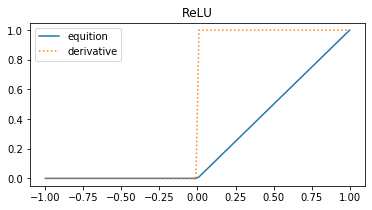

In [218]:
import matplotlib.pylab as plt
import numpy as np

class ReLU(ActFunc):
    def f(x):
        return np.maximum(x,0).astype(float)
    
    def d(y):
        '''Derivative of ReLU
        
        ReLU is monotonic,
        such that we can forward the activation potential directly.
        '''
        return (y > 0).astype(float)

#test
x = np.linspace(-1,1,100)
plt.figure(figsize=(6,3))
plt.plot(x, ReLU.f(x), label='equition')
plt.plot(x, ReLU.d(ReLU.f(x)), ':', label='derivative')
plt.title("ReLU")
plt.legend()
plt.show()

### Identity

Last but not least, we implement a simple utility for an identical activation.
This activation is required i.e. for regression.

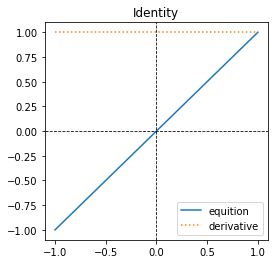

In [336]:
import numpy as np
class Identity(ActFunc):
    def f(x):
        return x
    
    def d(y):
        return np.ones(y.shape)

#test
x = np.linspace(-1,1,2)
plt.figure(figsize=(4,4))
plt.plot(x, Identity.f(x), label='equition')
plt.plot(x, Identity.d(Identity.f(x)), ':', label='derivative')
plt.title("Identity")
plt.axvline(color='k', linewidth=0.8, linestyle='--')
plt.axhline(color='k', linewidth=0.8, linestyle='--')
plt.legend()
plt.show()

# 1. Implement a Regression Network

Implement a regression network for the Engery Efficiency dataset.
I guess this dataset descripes the termal exchange of a building to its environment.
The dataset has 2 Values (t):

- Heating load, and
- Cooling load

And 8 features:

- Relative compactness,
- Surface area,
- Wall area,
- Roof area,
- Overall hight,
- Orientation,
- Glazing area, and
- Glazing area distribution.

We are required to define a feature-vector out of these features and predict the heating load of the buildings, by minimizing the "sum-of-squares" error function:

$$
\begin{equation}
E(w) = \sum_{n=1}^{N}{(t_n - y(X_n;w))^2}
\tag{6.1}
\end{equation}
$$

Thus the deravitive:

$$
\begin{equation}
E'(w) = (t - y(X;w)) * 2
\tag{6.2}
\end{equation}
$$

While the evaluation should be processed by the "root-mean-square" error,

$$
\begin{equation}
E_{RMS}(w) = \sqrt{\frac{1}{N} \sum_{n=1}^{N}{(t_n - y(X_n;w))^2}}
\tag{6.3}
\end{equation}
$$

Thus the derivative:

$$
\begin{equation}
E'_{RMS}(w) = \frac{t - y(X;w)}{N}
\tag{6.4}
\end{equation}
$$

In [131]:
import numpy as np

class LossFunc:
    '''A typedef for Loss Functions'''
    pass

class SOS(LossFunc):
    '''Sum of Squares error'''
    def f(t, y):
        return np.sum(np.power(t - y, 2))
    
    def d(t, y):
        return (t - y) * 2
    
class RMS(LossFunc):
    '''Root Mean Square error'''
    def f(t, y):
        return np.power(SOS.f(t, y) / t.size, 0.5)
    
    def d(t, y):
        return (t - y) / t.size

#test
print("SOS.f", SOS.f(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("SOS.d", SOS.d(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("RMS.f", RMS.f(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("RMS.d", RMS.d(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))

SOS.f 26
SOS.d [ 0 -1  0  5  0]
RMS.f 2.280350850198276
RMS.d [ 0.  -0.2  0.   1.   0. ]


## Load and prepare Energy Efficiency Data

In [327]:
import numpy as np

def unpack_EE_data():
    '''Loads and converts the EnergyEfficiency_data.csv
    
    Returns:
        data: A numpy.array with all the data samples.
        N: The number of converted samples.
    '''
    raw = np.genfromtxt('EnergyEfficiency_data.csv', skip_header=1, delimiter=',')
    N = raw.shape[0]
    data = np.zeros((N,17))
    data[:,:3] = raw[:,:3]     #comp, surf, wall
    data[:,3] = raw[:,3]       #roof
    data[:,4] = raw[:,4]       #hight
    data[:,5] = raw[:,5] == 2  #ori north
    data[:,6] = raw[:,5] == 3  #ori east
    data[:,7] = raw[:,5] == 4  #ori south
    data[:,8] = raw[:,5] == 5  #ori west
    data[:,9] = raw[:,6]       #area
    data[:,10] = raw[:,7] == 1 #area uniform
    data[:,11] = raw[:,7] == 2 #area north
    data[:,12] = raw[:,7] == 3 #area east
    data[:,13] = raw[:,7] == 4 #area south
    data[:,14] = raw[:,7] == 5 #area west
    data[:,15:] = raw[:,8:]    #heat, cold
    return data, N

def gen_EE_data(data, epochs, batch_size=None, with_trails=False,
                features=[i for i in range(15)],
                labels=[-2, -1]
               ):
    '''A generator function that iterates batch-wise for a given number of epochs.
    
    Accumulates samples according to batch_size and
    Yields the batch.
    
    Args:
        data: The dataset, a numpy.array.
        epochs: How many time to iterate though the dataset.
        batch_size: How many samples per batch.
            None = take the whole dataset.
        with_trails: Should it also yield incomplete batches?
            Warning: Trails could iritate the training process.
        features: Indicates where the features are.
        labels: Indicates where the labels are.
    
    Yields:
        X: The sample batch.
        T: A batch with the target labels.
        e: The current epoch.
        step: The current step counter.
    '''
    batch_size = batch_size if batch_size else data.shape[0]
    step = 0
    K = len(labels)
    F = len(features)
    N = data.shape[0]
    X = np.zeros((batch_size, F))
    T = np.zeros((batch_size, K))
    for e in range(epochs):
        for n in range(N):
            i = int(step % batch_size)
            X[i] = data[n,features]
            T[i] = data[n,labels]
            step += 1
            is_trail = not with_trails and n+batch_size >= N
            if not step % batch_size:
                yield X, T, e+is_trail, step
        if with_trails and step % batch_size:
            yield X[:i], T[:i], e+1, step

def split_data(data, N, split):
    shuffle = np.arange(N)
    np.random.shuffle(shuffle)
    split = int(N*split)
    train_idx = shuffle[:split]
    val_idx = shuffle[split:]
    train = data[train_idx]
    val = data[val_idx]
    return train, val, train_idx, val_idx

def normalize_data(data, mean=None, var=None):
    mean = mean if not mean is None else np.mean(data, axis=0)
    var = var if not var is None else np.sqrt(np.var(data, axis=0))*2
    data = (data - mean) / (var + (var==0))
    return data, mean, var

data, N = unpack_EE_data()
train, val, train_idx, val_idx = split_data(data, N, 0.75)

#test
print(data[:3])
print("Data Shape:", data.shape)

[[  0.98 514.5  294.   110.25   7.     1.     0.     0.     0.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.98 514.5  294.   110.25   7.     0.     1.     0.     0.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.98 514.5  294.   110.25   7.     0.     0.     1.     0.     0.
    0.     0.     0.     0.     0.    15.55  21.33]]
Data Shape: (768, 17)


## Configure the Regression Network

Now let's configure our network.
Thanks to Pythons prototyping feature, we simply add each layer to our NeuralNetwork instance.
For a more photonic initalization of the parameters we define a function `init_params`.
With this function we define how many inputs our layer expects and how many outputs this layer will produce.
The number of inputs must be equivalent to the number of nodes the previous layer has,
while output it the number of nodes the current layer has.

Furthermore, here are some more hyper-parameters in the parameter initialization,
such as weight-scaling, the use of bias and the initalization itself.
In default we choose an unscaled natural distributed random generator with bias.

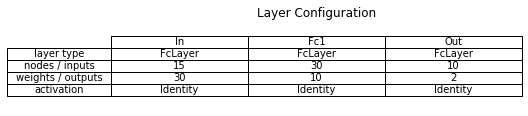

Nodes: 15 - 30 - 10 - 2


In [358]:
import matplotlib.pyplot as plt
import numpy as np

def init_params(inp, outp, scale=1, bias=True, init_func=np.random.randn):
    '''Initialize parameters.
    
    Args:
        inp: How many inputs the layer should absorb.
        outp: How many outputs the layer should produce.
        scale: Scaling of the initial parameters.
        bias: True, if a bias should be used, otherwise False.
        init_func: Alter the initialization function.
            (default) np.random.randn
    Returns:
        weights: A 2-dimensional matrix of weights.
        bias: Either 0 or a vector of biases for each node.
    '''
    weights = init_func(inp, outp)
    while not np.all(weights):
        malicious = weights==0.0
        weights[malicious] = init_func(malicious.shape)
    weights *= scale
    return weights, np.zeros(outp) if bias else 0

def init_EE_network(epochs, batch_size):
    '''Initialize a new Regression Network for the EE dataset.
    
    Args:
        epochs: How many epoch for the training.
        batch_size: How many samples per mini-batch.
    
    Returns:
        A Regression Network for the EE dataset.
    '''
    nn = NeuralNetwork(
        lambda: gen_EE_data(train, epochs, batch_size),
        lambda: gen_EE_data(val, 1, 1),
        SOS,
        RMS
    )

    nn.In = FcLayer(init_params(15, 30, scale=1),
                  Identity,
                  nn.gen_input,
                  None,
                  #clipping=1
                 )

    nn.Fc1 = FcLayer(init_params(30, 10, scale=1),
                  Identity,
                  nn.In.pull_forward,
                  nn.In.push_backward,
                  #clipping=1
                 )

    nn.Out = FcLayer(init_params(10, 2, scale=1),
                  Identity,
                  nn.Fc1.pull_forward,
                  nn.Fc1.push_backward
                 )
    
    # let's map the model to a dictionery for easy access
    nn.model = {
        'In':(nn.In.w, nn.In.b),
        'Fc1':(nn.Fc1.w, nn.Fc1.b),
        'Out':(nn.Out.w, nn.Out.b)
    }
    return nn

#test
def plot_net_conf(nn):
    '''Plots the Network configuration in a table
    
    Args:
        nn: The NeuralNetwork
    '''
    col_labels = []
    ltype = []
    nodes = []
    outputs = []
    act_funcs = []
    for k,v in nn.model.items():
        layer = getattr(nn, k)
        ltype.append(layer.__class__.__name__)
        col_labels.append(k)
        nodes.append(v[0].shape[0])
        outputs.append(v[0].shape[1])
        act_funcs.append(layer.act.__name__)

    plt.figure(figsize=(6,1.5))
    plt.axis('off')
    plt.axis('tight')
    plt.tight_layout()
    plt.table(cellText=[ltype, nodes, outputs, act_funcs],
              rowLabels=['layer type', 'nodes / inputs', 'weights / outputs', 'activation'],
              colLabels=col_labels,
              cellLoc='center',
              rowLoc='center',
              loc='center'
             )
    plt.title("Layer Configuration")
    plt.show()
    pass

nn = init_EE_network(1, 1)
plot_net_conf(nn)
print("Nodes:", nn.In.w.shape[0], '-', nn.Fc1.w.shape[0], '-', nn.Out.w.shape[0], '-', nn.Out.w.shape[1])

Note that our Output-Layer has 2 outputs.
Remember that the Energy Efficiency dataset has 2 targets:

- Heating Load and
- Cooling Load

I choose to regress for both targets,
because even a target can contribute useful information to the training process.

## Save and Load

Copy, save and load are important functionalities during the training process.
Each epoch we will test our model against a validation set.
While our model approaches more and more the training set,
the model will reach a point where it start to overfit
and the loss of the validation will rise up again.
Before this happen we want to caputre the best model,
by storing the best result after each epoch.
Fortunatelly, copying, storing and loading are easy to implement with Pickle.

In [351]:
import pickle

def dump(nn, model):
    '''Dumps the params of a given NeuralNetwork into a dictionary.
    
    The dictionary must have the attribute name of the layer as a key.
    E.g.: nn.layer1 --> model['layer1']
    
    Agrs:
        nn: The NeuralNetwork
        model: A dict where the params get stored at
    '''
    for k,v in model.items():
        layer = getattr(nn, k)
        model[k] = (layer.w.copy(), 0 if layer.b is 0 else layer.b.copy())
    pass

def assign(model, nn):
    '''Assigns the params of a given dictionary into a NeuralNetwork.
    
    The dictionary must have the attribute name of the layer as a key.
    E.g.: model['layer1'] --> nn.layer1
    
    Agrs:
        model: A dict with parameters
        nn: The NeuralNetwork where the params get stored at
    '''
    for k,v in model.items():
        layer = getattr(nn, k)
        layer.w = model[k][0].copy()
        layer.b = 0 if model[k][1] is 0 else model[k][1].copy() 
    pass

def save(model, fname):
    '''Saves the model to a pickle file.
    
    The model is a dictionary.
    The weights and bias should be stored layer-wise as a tuble.
    Note: It's recommended to coincide the naming!
    E.g.: model['layer1'] = (nn.layer1.w, nn.layer1.b)
    
    Args:
        model: A dict with the parameters.
        fname: The path/file name to be stored at.
    '''
    with open(fname, 'wb') as file:
        pickle.dump(model, file)
    pass

def load(nn, fname):
    '''Loads a pickle file to a NeuralNetwork.
    
    Note: Make sure that the layers have the same naming as in the file.
    
    Args:
        nn: The NeuralNetwork
        fname: The path/file name to be loaded.
    '''
    with open(fname, 'rb') as file:
        obj = pickle.load(file)
    for k,v in obj.items():
        if hasattr(nn, k):
            layer = getattr(nn, k)
            layer.w = v[0]
            layer.b = v[1]
    dump(nn, nn.model)
    pass

#test
dump(nn, nn.model)
assign(nn.model, nn)
save(nn.model, "test.pkl")
load(nn, "test.pkl")

## Train the Regression Network

Now, we are ready to define our training script.
All we need to do is to define a several hyper-parameters,
reload the data, initialize the NeuralNetwork
and define a short helper function that loggs and iterates through the training steps.

There are a lot of hidden hyper-parameters by training a Neural Network.
One of them is the seed of the random generator for the parameter initialization.
Furthermore, the learning-rate and batch-size need to be adjusted on each other.
Another huge impact comes from the fact if our data is normalized or not.
An unnormalized dataset could cause number overflows,
while a normalized dataset could cause vanishing gradients.
Hence, for normalized data, we should consider to use more ReLU oder Identity activations,
while for unnormalized data Sigmoid and TanH could help to prevent overflows.

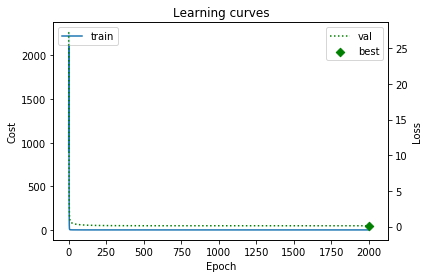

Best Epoch: 2000 with a Loss of: 0.11473891245736514


In [384]:
import numpy as np
#Setup some hyper-parameters
np.random.seed(1) #how about your lucky number?
epochs = 2000
batch_size = None #None for complete dataset
lr = 1e-5
lr_dec = 1e-15

#reload data
data, N = unpack_EE_data()
train, val, train_idx, val_idx = split_data(data, N, 0.75)
train, mean, var = normalize_data(train)
val, _, _ = normalize_data(val, mean, var)
data, _, _ = normalize_data(data, mean, var)

#reset the model
nn = init_EE_network(epochs, batch_size)

def run_training(nn, lr, lr_dec):
    epoch = 0
    cost = 0
    
    for Z in nn.train(nn.Out, lr, lr_dec):
        cost += Z / train.shape[0]
        if nn.epoch > epoch:
            loss = 0
            epoch = nn.epoch
            
            for Zv in nn.val(nn.Out):
                loss += Zv / val.shape[0]
                
            yield loss, cost, epoch
            cost = 0
    pass

def train_n_plot(nn, lr, lr_dec, checkpoint=None, every=None):
    training = []
    validation = []
    best_loss = None
    best_epoch = 0
    
    for loss, cost, epoch in run_training(nn, lr, lr_dec):
        training.append(cost)
        validation.append(loss)
        if best_loss is None or loss <= best_loss:
            best_loss = loss
            best_epoch = epoch
            dump(nn, nn.model)
        if checkpoint:
            save(nn.model, '{}_best.pkl'.format(checkpoint))
        if checkpoint and every and not epoch % every:
            model = dict.fromkeys(nn.model.keys(), [])
            dump(nn, model)
            save(model, '{}_{}.pkl'.format(checkpoint, epoch))
    
    ax_l = plt.figure().subplots(1)
    ax_l.plot(range(nn.epoch), training, label='train')
    ax_l.set_xlabel("Epoch")
    ax_l.set_ylabel("Cost")

    ax_r = ax_l.twinx()
    ax_r.plot(range(nn.epoch), validation, 'g:', label='val')
    ax_r.scatter(best_epoch, best_loss, color='g', marker='D', zorder=3, label='best')
    ax_r.set_ylabel("Loss")

    ax_l.legend(loc=2)
    ax_r.legend()

    plt.title("Learning curves")
    plt.show()
    print("Best Epoch:", best_epoch, "with a Loss of:", best_loss)
    return best_epoch, best_loss

#test
_, best_model = train_n_plot(nn, lr, lr_dec, "checkpointEE")

## Qualitative Evaluation of the Regression

In this section we evaluate our model qualitatively.
This means we want a visualization of the regression,
such that we can subjectively percept the performance of the prediction.
For this purpose, we need to unshuffle the data first.
Then, we replace the input generator with a generator of sorted data
and run the validation process.

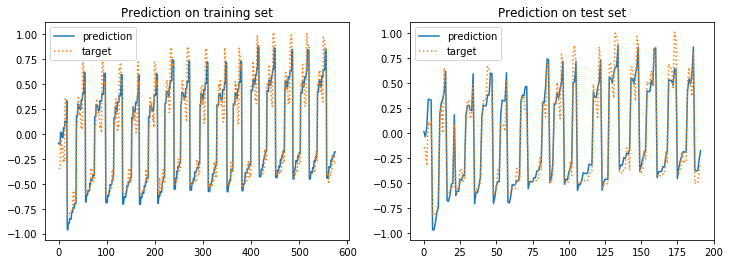

In [371]:
def plot_prediction(nn, features=[i for i in range(15)], labels=[-2, -1]):
    '''
    Unshuffles the data and runs two validations.
    First, for the training set.
    Second, for the validation set.
    Plots the two results as a line-chart
    
    Args:
        nn: The NeuralNetwork.
        features: For predictions on a subset.
        labels: For predictions on a subset.
    '''
    nn.val_set = lambda: gen_EE_data(train[np.argsort(train_idx)], 1, 1, False, features, labels)
    nn.loss = RMS
    target = []
    pred = []
    for Zv in nn.val(nn.Out):
        target.append(nn.T[0][0])
        pred.append(nn.Out.y[0][0])

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,2)
    ax[0].plot(range(len(pred)), pred, label='prediction')
    ax[0].plot(range(len(target)), target, label='target', linestyle=':')
    ax[0].set_title("Prediction on training set")
    ax[0].legend()

    nn.val_set = lambda: gen_EE_data(val[np.argsort(val_idx)], 1, 1, False, features, labels)
    target = []
    pred = []
    for Zv in nn.val(nn.Out):
        target.append(nn.T[0][0])
        pred.append(nn.Out.y[0][0])

    ax[1].plot(range(len(pred)), pred, label='prediction')
    ax[1].plot(range(len(target)), target, label='target', linestyle=':')
    ax[1].set_title("Prediction on test set")
    ax[1].legend()
    
    plt.show()
    pass

assign(nn.model, nn) #regenerate the best model
plot_prediction(nn)

## Impact of Feature Selection

We are asked to perform an evaluation of the impact of feature selection.
We want to find 7 features of the dataset that influence the enegry load significantly.

Let's take a look at the variance of the weights of the Input-Layer.
A neuron with a low variance of weights to each of the next Layer's neurons implies that this neuron is literally telling each neuron the same stuff.
Such a neuron seems to be unnecessary, because it could be approximated with a constant.
Hence, let's try to take the 7 input features with the highest variance of weights and compare those with the 7 features with the lowest variance.

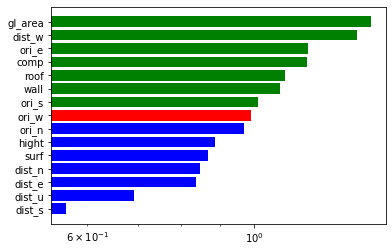

7-Top Features: ['gl_area' 'dist_w' 'ori_e' 'comp' 'roof' 'wall' 'ori_s']
7-Worst Features: ['ori_n' 'hight' 'surf' 'dist_n' 'dist_e' 'dist_u' 'dist_s']


In [340]:
def sort_features(nn):
    features = np.var(nn.In.w, axis=1)
    sort_idx = np.argsort(features)[::-1]
    features = features[sort_idx]
    return features, sort_idx

def plot_input_weights():
    features, idx = sort_features(nn)
    y_axis = np.arange(features.size)
    labels = np.array(['comp', 'surf', 'wall', 'roof', 'hight',
              'ori_n', 'ori_e', 'ori_s', 'ori_w',
              'gl_area',
              'dist_u', 'dist_n', 'dist_e', 'dist_s', 'dist_w'
              ])
    labels = labels[idx]
    colors = ['g'] * 7 + ['r'] + ['b'] * 7
    plt.barh(y_axis, features[::-1], color=colors[::-1])
    plt.xscale('log')
    plt.yticks(y_axis, labels[idx][::-1])
    plt.show()
    print("7-Top Features:", labels[idx[:7]])
    print("7-Worst Features:", labels[idx[-7:]])
    pass

plot_input_weights()

### Configure the Sub-Net

In [376]:
import numpy as np
#Setup some hyper-parameters
np.random.seed(1) #how about your lucky number?
epochs = 2000
batch_size = None #None for complete dataset
lr = 1e-5
lr_dec = 1e-10

def init_EE_subset_net(subset):
    nn = NeuralNetwork(
        lambda: gen_EE_data(train, epochs, batch_size, False, subset),
        lambda: gen_EE_data(val, 1, 1, False, subset),
        SOS,
        RMS
    )

    nn.In = FcLayer(init_params(7, 30, scale=1),
                  Identity,
                  nn.gen_input,
                  None,
                  #clipping=1
                 )

    nn.Fc1 = FcLayer(init_params(30, 10, scale=1),
                  Identity,
                  nn.In.pull_forward,
                  nn.In.push_backward,
                  #clipping=1
                 )

    nn.Out = FcLayer(init_params(10, 2, scale=1),
                  Identity,
                  nn.Fc1.pull_forward,
                  nn.Fc1.push_backward
                 )
    
    # let's map the model to a dictionery for easy access
    nn.model = {
        'In':(nn.In.w, nn.In.b),
        'Fc1':(nn.Fc1.w, nn.Fc1.b),
        'Out':(nn.Out.w, nn.Out.b)
    }
    return nn

_, idx = sort_features(nn)

### Validation of High-Var Features

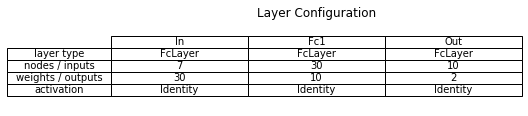

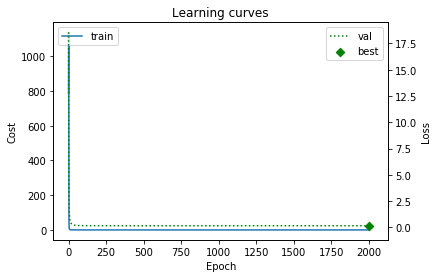

Best Epoch: 2000 with a Loss of: 0.15316134354413907


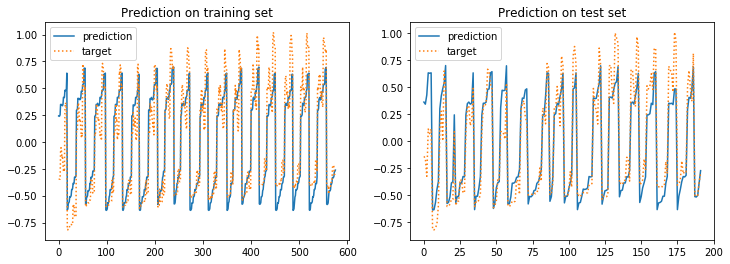

In [380]:
nn_sub = init_EE_subset_net(idx[:7])
plot_net_conf(nn_sub)
_, high_var_loss = train_n_plot(nn_sub, lr, lr_dec)
assign(nn_sub.model, nn_sub) #regenerate the best model
plot_prediction(nn_sub, idx[:7])

### Validation of Low-Var Features

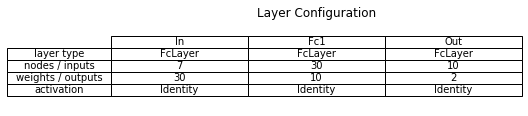

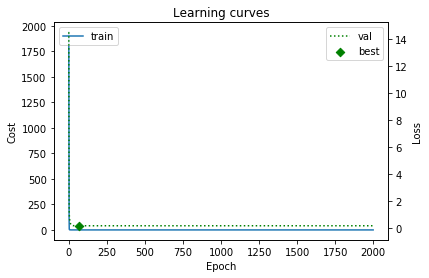

Best Epoch: 68 with a Loss of: 0.16756974914243994


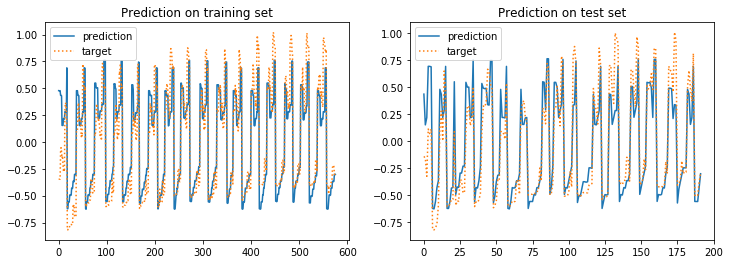

Delta HighVar - LowVar: 0.15316134354413907 0.16756974914243994


In [381]:
nn_sub = init_EE_subset_net(idx[-7:])
plot_net_conf(nn_sub)
_, low_var_loss = train_n_plot(nn_sub, lr, lr_dec)
assign(nn_sub.model, nn_sub) #regenerate the best model
plot_prediction(nn_sub, idx[-7:])

### Conclusion of Feature Selection

It concludes that the selection of high variant weighted features performs about 1.4% better than the selection of low variant weighted features.
However, both sub-models under-perform the original model with all 15 features.
The model trained on all 15 features outperforms HighVar for about 3.8%.

In [385]:
print("Delta LowVar vs. HighVar:", low_var_loss - high_var_loss)
print("Delta HighVar vs. AllFeatures:", high_var_loss - best_model)

Delta LowVar vs. HighVar: 0.014408405598300866
Delta HighVar vs. AllFeatures 0.03842243108677393


# 2. Implement a Classifier

Implement a classification network for the Ionosphere dataset.
The Ionosphere dataset has 34 numerical features and 1 label,
representing 2 classes (g=good, b=bad).

We are asked train a classifier of 'good' and 'bad' ionospheres by minimizing the cross-entropy:

$$
\begin{equation}
E(w) = -\sum_{n=1}^{N}\sum_{k=1}^{K} t_{nk} \log y_k (X_n, w)
\tag{7.1}
\end{equation}
$$

While the derivative we can approximate with:

$$
\begin{equation}
E'(w) = (t - y(X, w))
\tag{7.2}
\end{equation}
$$

Furthermore, we require a loss function to validate the performance:

$$
\begin{equation}
E(w) = \sum_{n=1}^{N}(z) \\
\text{where: } z
    \begin{cases}
        1 & \text{for } t = y \\
        0 & \text{otherwise}
    \end{cases}
\tag{7.4}
\end{equation}
$$

Please allow us to normalize the loss function by the number of samples $N$,
to obtain a better readable error value in the range of $0..1$:

$$
\begin{equation}
\hat{E}(w) = \frac{E(w)}{N} \\
\hat{E'}(w) = \frac{E'(w)}{N}
\tag{7.4}
\end{equation}
$$

In [402]:
import numpy as np
from scipy.special import xlogy, xlog1py

class CE:
    '''Cross Entropy'''
    def f(t,y):
        #return -np.sum(np.sum(np.dot(t, np.log(y.T)), axis=1)) / t.shape[1] #multy class
        #return -np.sum(np.dot(t, np.log(y.T)) + np.dot(1 - t, np.log(1 - y.T))) / t.shape[1]
        return -np.sum(xlogy(t, y) + xlog1py(1 - t, -y)) / t.shape[1]
    
    def d(t,y):
        return (t - y) / t.shape[1]

class AMax:
    '''Arg Max Pooling'''
    def f(t,y):
        return np.sum(np.argmax(t, axis=1) != np.argmax(y, axis=1)) / t.shape[0]
    
    def d(t,y):
        z = np.zeros(y.shape)
        z[:,np.argmax(y, axis=1)[0]] = 1
        return (t - z) / t.shape[1]

#test
print("CE.f", CE.f(np.array([[1,0]]), np.array([[1,0]])))
print("CE.d", CE.d(np.array([[1,0],[0,1]]), np.array([[0,0],[1,1]])))
print("AMax.f", AMax.f(np.array([[-1,1]]), np.array([[.9,.1]])))
print("AMax.d", AMax.d(np.array([[1,0]]), np.array([[.1,.9]])))

CE.f -0.0
CE.d [[ 0.5  0. ]
 [-0.5  0. ]]
AMax.f 1.0
AMax.d [[ 0.5 -0.5]]


## Load and prepare Ionosphere Data

In [401]:
import numpy as np
import pandas as pd

def unpack_Ion_data():
    raw = pd.read_csv("ionosphere_csv.csv")
    raw = raw.values
    N = raw.shape[0]
    data = np.zeros((N, raw.shape[1]+1))
    data[:,:-2] = raw[:,:-1]
    data[:,-2] = raw[:,-1] == 'g'
    data[:,-1] = raw[:,-1] == 'b'
    return data, N

def gen_Ion_data(data, epochs, batch_size=None, with_trails=False):
    batch_size = batch_size if batch_size else data.shape[0]
    step = 0
    N = data.shape[0]
    K = 2
    F = data.shape[1] - K
    X = np.zeros((batch_size, F))
    T = np.zeros((batch_size, K))
    for e in range(epochs):
        for n in range(N):
            i = int(step % batch_size)
            X[i] = data[n,:F]
            T[i] = data[n,-K:]
            step += 1
            is_trail = not with_trails and n+batch_size >= N
            if not step % batch_size:
                yield X, T, e+is_trail, step
        if with_trails and step % batch_size:
            yield X[:i], T[:i], e+1, step

data, N = unpack_Ion_data()

#test
print(data[:3])
print("Data Shape:", data.shape)

[[ 1.       0.       0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708
   1.       0.0376   0.85243 -0.17755  0.59755 -0.44945  0.60536 -0.38223
   0.84356 -0.38542  0.58212 -0.32192  0.56971 -0.29674  0.36946 -0.47357
   0.56811 -0.51171  0.41078 -0.46168  0.21266 -0.3409   0.42267 -0.54487
   0.18641 -0.453    1.       0.     ]
 [ 1.       0.       1.      -0.18829  0.93035 -0.36156 -0.10868 -0.93597
   1.      -0.04549  0.50874 -0.67743  0.34432 -0.69707 -0.51685 -0.97515
   0.05499 -0.62237  0.33109 -1.      -0.13151 -0.453   -0.18056 -0.35734
  -0.20332 -0.26569 -0.20468 -0.18401 -0.1904  -0.11593 -0.16626 -0.06288
  -0.13738 -0.02447  0.       1.     ]
 [ 1.       0.       1.      -0.03365  1.       0.00485  1.      -0.12062
   0.88965  0.01198  0.73082  0.05346  0.85443  0.00827  0.54591  0.00299
   0.83775 -0.13644  0.75535 -0.0854   0.70887 -0.27502  0.43385 -0.12062
   0.57528 -0.4022   0.58984 -0.22145  0.431   -0.17365  0.60436 -0.2418
   0.56045 -0.38238  1.       0.   

## Configure Classification Network

Classification is the accumulation of propabilities.
Those are never negative.
Therefore activation functions such as Sigmoid and ReLU are applicable.
They ensure that the activation potential is always $>=0$.

We chose a Sigmoid activation for the input layer
which automatically normalizes our date in a range between $0..1$
The Hidden-Layers we activate with ReLU to keep the gradients up.
Finally the Output-Layer we activate one more time with Sigmoid,
such that we obtain a normalized propability between the 2 classes.

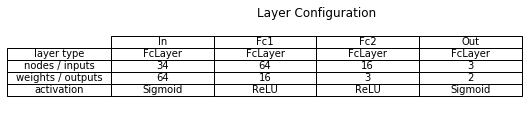

In [423]:
import matplotlib.pyplot as plt
import numpy as np

def init_Ion_network(epochs, batch_size):
    nn = NeuralNetwork(
        lambda: gen_Ion_data(train, epochs, batch_size),
        lambda: gen_Ion_data(val, 1, 1),
        CE,
        AMax
    )

    nn.In = FcLayer(init_params(34, 64, scale=1),
                  Sigmoid,
                  nn.gen_input,
                  None,
                  #clipping=1
                 )

    nn.Fc1 = FcLayer(init_params(64, 16, scale=.1),
                  ReLU,
                  nn.In.pull_forward,
                  nn.In.push_backward,
                  #clipping=1
                 )
    
    nn.Fc2 = FcLayer(init_params(16, 3, scale=.1),
                  ReLU,
                  nn.Fc1.pull_forward,
                  nn.Fc1.push_backward,
                  #clipping=1
                 )

    nn.Out = FcLayer(init_params(3, 2, scale=1),
                  Sigmoid,
                  nn.Fc2.pull_forward,
                  nn.Fc2.push_backward,
                  #clipping=1
                 )
    
    # let's map the model to a dictionery for easy access
    nn.model = {
        'In':(nn.In.w, nn.In.b),
        'Fc1':(nn.Fc1.w, nn.Fc1.b),
        'Fc2':(nn.Fc2.w, nn.Fc2.b),
        'Out':(nn.Out.w, nn.Out.b)
    }
    return nn

plot_net_conf(init_Ion_network(1, 1))

## Train the Classification Network

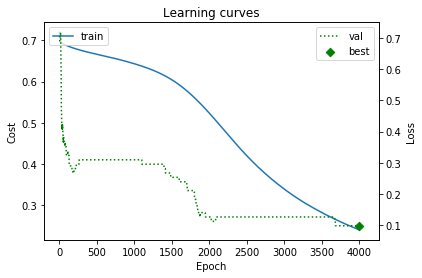

Best Epoch: 4000 with a Loss of: 0.09859154929577464


In [426]:
import numpy as np
#Setup some hyper-parameters
np.random.seed(1) #how about your lucky number?
epochs = 4000
batch_size = None #None for complete dataset
lr = 1e-4
lr_dec = 1e-10

#reload data
data, N = unpack_Ion_data()
train, val, train_idx, val_idx = split_data(data, N, 0.8)
train, mean, var = normalize_data(train, mean=0)
val, _, _ = normalize_data(val, mean, var)
data, _, _ = normalize_data(data, mean, var)

#reset model
nn2 = init_Ion_network(epochs, batch_size)

#run training
_, _ = train_n_plot(nn2, lr, lr_dec, "checkpointIon", 500)

In [427]:
def print_prediction(nn):
    nn.val_set = lambda: gen_Ion_data(train[np.argsort(train_idx)], 1,  None)
    nn.loss = AMax
    for Zv in nn.val(nn.Out):
        print("Accuracy on training set:\t", (1-Zv)*100, "%")

    nn.val_set = lambda: gen_Ion_data(val[np.argsort(val_idx)], 1, None)
    pred = []
    for Zv in nn.val(nn.Out):
        print("Accuracy on validation set:\t", (1-Zv)*100, "%")
    pass

assign(nn2.model, nn2) #regenerate the best model
print_prediction(nn2)

Accuracy on training set:	 96.07142857142857 %
Accuracy on validation set:	 90.14084507042254 %


## Visualize Learnd Feature Dimensions

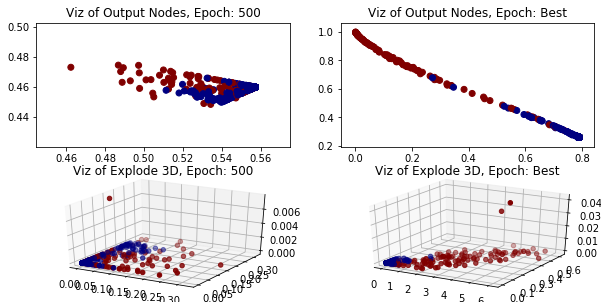

Ground Truth -> Red: good, Blue: bad


In [431]:
from mpl_toolkits.mplot3d import Axes3D

def viz_dims(nn):
    nn.val_set = lambda: gen_Ion_data(data, 1,  None)
    
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    
    load(nn, "checkpointIon_500.pkl")
    for Zv in nn.val(nn.Out):
        gt = np.argmax(nn.T, axis=1) #+ np.argmax(nn.Out.y, axis=1)
        ax1.scatter(nn.Out.y[:,0], nn.Out.y[:,1], c=gt, cmap='jet')
        ax1.set_title("Viz of Output Nodes, Epoch: 500")
        ax3.scatter(nn.Fc2.y[:,0], nn.Fc2.y[:,1], nn.Fc2.y[:,2], c=gt, cmap='jet')
        ax3.set_title("Viz of Explode 3D, Epoch: 500")
    
    load(nn, "checkpointIon_best.pkl")
    for Zv in nn.val(nn.Out):
        gt = np.argmax(nn.T, axis=1) #+ np.argmax(nn.Out.y, axis=1)
        ax2.scatter(nn.Out.y[:,0], nn.Out.y[:,1], c=gt, cmap='jet')
        ax2.set_title("Viz of Output Nodes, Epoch: Best")
        ax4.scatter(nn.Fc2.y[:,0], nn.Fc2.y[:,1], nn.Fc2.y[:,2], c=gt, cmap='jet')
        ax4.set_title("Viz of Explode 3D, Epoch: Best")
        
    plt.show()
    print("Ground Truth -> Red: good, Blue: bad")
    pass

viz_dims(nn2)

### Conclusion of Feature Visualization

It appears that the blue datapoints stuck on the 0-plane in the early epoch.
This could be caused by the ReLU activation.
Mind that this dataset was not normalized in the pre-processing.
We expected that the Sigmoid activation could do this for us in the Input-Layer.

Nevertheless, the NeuralNatwork was able to stretch the configuration space and release the datapoints from the 0-axis,
such that a classification with 90% accuracy is possible.